# Using Virtual Data Stores to Compare Sea Surface Temperature Gradients
#### *Author: Celia Ou, PO.DAAC*

## Summary
This notebook demonstrates how to open, subset, and compute the horizontal gradients of the [MUR SST](https://doi.org/10.5067/GHGMR-4FJ04) and [OSTIA](https://doi.org/10.5067/GHOST-4RM02) SST satellite data products, using the virtual dataset versions of these datasets available from PO.DAAC. The gradient computations follow the first few calculations and figures described in [this article](doi.org/10.3390/rs17152722) on the application of satellite-derived sea surface temperature gradients to examine seasonal and interannual variability off the California Coast. Documentation for the implementation of the MUR dataset can be found [in this design doc](https://github.com/earth-mover/icechunk-nasa/blob/main/design-docs/mursst-virtual-icechunk-store.md). For OSTIA and the usage of other PO.DAAC VDS's in general, see the [PO.DAAC Cookbook section on VDS](https://podaac.github.io/tutorials/quarto_text/UsingVirtualDatasets.html)

#### Sections
1. Examine the MUR dataset and compute SST gradient
2. Examine the OSTIA dataset and compute SST gradient
3. Interpolate MUR to OSTIA and compute the gradient for comparison

## Requirements

### Compute Environment
**AWS instance running in us-west-2**: NASA Earthdata Cloud data in S3 can be directly accessed via temporary credentials; this access is limited to requests made within the US West (Oregon) (code: `us-west-2`) AWS region.

**Keep in mind**: For out-of-cloud use, you may run into access errors if trying to do computations with more than ~20 years of data due to limitations on the number of simultaneous data requests that can be made at once. For complex or large computations with VDS's, please be in the cloud in the same location as the data (for PO.DAAC this is `us-west-2`).

### Earthdata Login
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.
    
### Key packages:
- earthaccess
- fsspec
- numpy
- pandas
- xarray
- zarr
- icechunk
- metpy
- matplotlib
- scipy

## Import packages

In [11]:
# Access
import earthaccess
import fsspec

# Reading and data handling
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import icechunk
from icechunk.credentials import s3_credentials
from typing import Optional
import metpy
import metpy.calc as mpcalc
from metpy.units import units

# Plotting
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### Set zarr runtime configuration

Async and threading operations can be set via zarr.config. Please also see [zarr-python runtime configuration documentation](https://zarr.readthedocs.io/en/stable/user-guide/config.html).

* `async.concurrency` controls how many chunks can be fetched asynchronously at once.
* `threading.max_workers` determines how many threads handle the decompression or processing of those fetched chunks.

The default setting for `threading.max_workers` is `None` so presumably this uses all threads available.

In [12]:
# concurrency=300 seems to be a sweet spot for smaller EC2s. Fast open time of a few secconds for MUR.
zarr.config.set({
    'async': {'concurrency': 300, 'timeout': None},
    'threading': {'max_workers': 4}
})

#### Set the region and time range for both MUR and OSTIA datasets

In [13]:
# Bounding box for a region off the coast of California
lat_min = 30.
lat_max = 45.
lon_min = -140.
lon_max = -115.

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

##3 years
start_date = '2010-01-01'
end_date = '2012-12-31'

## 10 years
# start_date = '2010-01-01'
# end_date = '2019-12-31'

## 20 years
# start_date = '2002-09-01'
# end_date = '2022-08-31'

time_range =(start_date, end_date)

## Authenticate
Authenticate your Earthdata Login (EDL) information using the `earthaccess` python package as follows:

In [14]:
bucket_name = 'nasa-eodc-public'
store_name = "MUR-JPL-L4-GLOB-v4.1-virtual-v1"

earthaccess.login()
ea_creds = earthaccess.get_s3_credentials(daac='PODAAC')

storage_path = "s3://" + bucket_name + "/" + store_name +"/"
print(storage_path)

s3://nasa-eodc-public/MUR-JPL-L4-GLOB-v4.1-virtual-v1/


#### Initialize the repository for MUR icechunk

In [15]:
# get_repo subroutine 

def get_repo(bucket_name: str, store_name: str, ea_creds: Optional[dict] = None):
    storage = icechunk.s3_storage(
        bucket=bucket_name,
        prefix=f"icechunk/{store_name}",
        anonymous=True
    )

    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3://podaac-ops-cumulus-protected/", icechunk.s3_store(region="us-west-2")))

    repo_config = dict(
        storage=storage,
        config=config,
    )
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            {"s3://podaac-ops-cumulus-protected/": icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken'] )
            }
        )
        repo_config['authorize_virtual_chunk_access'] = earthdata_credentials
        #repo_config['virtual_chunk_credentials'] = earthdata_credentials

    return icechunk.Repository.open(**repo_config)

In [16]:
repo = get_repo(bucket_name=bucket_name, store_name=store_name, ea_creds=ea_creds)
session = repo.readonly_session(branch="main")

  2025-12-10T04:19:34.141303Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:274

  2025-12-10T04:19:34.141321Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:274

  2025-12-10T04:19:34.141325Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: Url prefix for s3:// containers must include a host
    at icechunk/src/virtual_chunks.rs:274

  2025-12-10T04:19:34.141329Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:274

  2025-12-10T04:19:34.141331Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:274



## **1. Examine the MUR dataset and compute SST gradient**

In [17]:
# fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [18]:
# %%time
# vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/MUR25-JPL-L4-GLOB-v04.2/MUR25-JPL-L4-GLOB-v04.2_virtual_s3.json"
# mur_ds = xr.open_dataset(
#     vds_link,
#     engine="kerchunk",
#     chunks={},
#     backend_kwargs={
#         "storage_options": {
#             "remote_protocol": "s3",
#             "remote_options": fs.storage_options
#         }
#     }
# )

CPU times: user 207 ms, sys: 41.4 ms, total: 249 ms
Wall time: 2.5 s


In [19]:
mur_ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)
print(mur_ds)
mur_ds

<xarray.Dataset> Size: 312GB
Dimensions:           (time: 8369, lat: 720, lon: 1440)
Coordinates:
  * time              (time) datetime64[ns] 67kB 2002-09-01T09:00:00 ... 2025...
  * lat               (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon               (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    mask              (time, lat, lon) float32 35GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.7, ACDD-1.3
    acknowledgment:             Please acknowledge t

<xarray.Dataset> Size: 312GB
Dimensions:           (time: 8369, lat: 720, lon: 1440)
Coordinates:
  * time              (time) datetime64[ns] 67kB 2002-09-01T09:00:00 ... 2025...
  * lat               (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon               (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    mask              (time, lat, lon) float32 35GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float64 69GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.7, ACDD-1.3
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_institution:        Jet Propulsion Laboratory
    creator_name:               JPL MUR SST project
    ...                         ...
    spatial_resolution:         0.25 degrees
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    summary:                    A low-resolution version of the MUR SST analy...
    time_coverage_resolution:   P1D
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

#### Subset MUR data to the region

In [20]:
mur_subset = mur_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range))
mur_subset

<xarray.DataArray 'analysed_sst' (time: 3652, lat: 60, lon: 100)> Size: 175MB
dask.array<getitem, shape=(3652, 60, 100), dtype=float64, chunksize=(1, 60, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01T09:00:00 ... 2019-12-31T09...
  * lat      (lat) float32 240B 30.12 30.38 30.62 30.88 ... 44.38 44.62 44.88
  * lon      (lon) float32 400B -139.9 -139.6 -139.4 ... -115.6 -115.4 -115.1
Attributes:
    coverage_content_type:  physicalMeasurement
    long_name:              analysed sea surface temperature
    standard_name:          sea_surface_foundation_temperature
    units:                  kelvin
    valid_max:              32767
    valid_min:              -32767

#### **Compute the SST gradient**

In [21]:
%%time
mur_mp = mur_subset.drop_attrs(deep=True) # drops attributes, including from coordinate variables
mur_mp.metpy.assign_crs(grid_mapping_name='latitude_longitude') # adds attribute needed for metpy.xarray.grid_deltas_from_dataarray(): metpy_crs
x, y = metpy.xarray.grid_deltas_from_dataarray(mur_mp,'actual') # compute distances between grid points, in meters

# convert to km, convert to DataArray with coordinates
x = xr.DataArray(x.to('km').squeeze(),coords=[mur_mp.lat,mur_mp.lon[1:]]) 
y = xr.DataArray(y.to('km').squeeze(),coords=[mur_mp.lat[1:],mur_mp.lon])

# pad lat/lon dimensions with NaN, "dequantify", and convert to Dask array with same chunk sizes as before
x = xr.concat([x, xr.DataArray(np.full([mur_mp.sizes['lat'],1],np.nan),coords=[mur_mp.lat,mur_mp.lon[:1]])],'lon').metpy.dequantify().chunk(mur_subset[0,:,:].chunksizes)
y = xr.concat([y, xr.DataArray(np.full([1,mur_mp.sizes['lon']],np.nan),coords=[mur_mp.lat[:1],mur_mp.lon])],'lat').metpy.dequantify().chunk(mur_subset[0,:,:].chunksizes)

# compute distance of 2 grid cells
xgrid = x + x.shift(lon=1, fill_value=np.nan) 
ygrid = y + y.shift(lat=1, fill_value=np.nan)

# repeat over the time dimenstion, and chunk to the original sizes
dx = xgrid.expand_dims(dim={"time": mur_mp.time}, axis=0).chunk(mur_subset.chunksizes)
dy = ygrid.expand_dims(dim={"time": mur_mp.time}, axis=0).chunk(mur_subset.chunksizes)

# Compute the gradient (magnitude)
delta_x = (mur_subset - mur_subset.shift(lon=2, fill_value=np.nan)).shift(lon=-1, fill_value=np.nan)/(dx)
delta_y = (mur_subset - mur_subset.shift(lat=2, fill_value=np.nan)).shift(lat=-1, fill_value=np.nan)/(dy)
sst_grad = np.sqrt(np.square(delta_x)+np.square(delta_y))

CPU times: user 1.16 s, sys: 31.6 ms, total: 1.19 s
Wall time: 1.19 s


#### **Seasonal average of the SST gradient, with "winter" being January through March**

In [22]:
sst_grad_seasonal = sst_grad.groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean()
sst_grad_seasonal

<xarray.DataArray (season: 4, lat: 60, lon: 100)> Size: 192kB
dask.array<stack, shape=(4, 60, 100), dtype=float64, chunksize=(1, 60, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 240B 30.12 30.38 30.62 30.88 ... 44.38 44.62 44.88
  * lon      (lon) float32 400B -139.9 -139.6 -139.4 ... -115.6 -115.4 -115.1
  * season   (season) <U3 48B 'JFM' 'AMJ' 'JAS' 'OND'

#### **Seasonal root-mean-square (RMS) of the SST gradient**

In [23]:
rms_seasonal = np.sqrt(np.square(sst_grad).groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean())
rms_seasonal

<xarray.DataArray (season: 4, lat: 60, lon: 100)> Size: 192kB
dask.array<sqrt, shape=(4, 60, 100), dtype=float64, chunksize=(1, 60, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 240B 30.12 30.38 30.62 30.88 ... 44.38 44.62 44.88
  * lon      (lon) float32 400B -139.9 -139.6 -139.4 ... -115.6 -115.4 -115.1
  * season   (season) <U3 48B 'JFM' 'AMJ' 'JAS' 'OND'

#### **Plot the seasonal SST gradient**

CPU times: user 1min 59s, sys: 5.65 s, total: 2min 4s
Wall time: 1min 8s


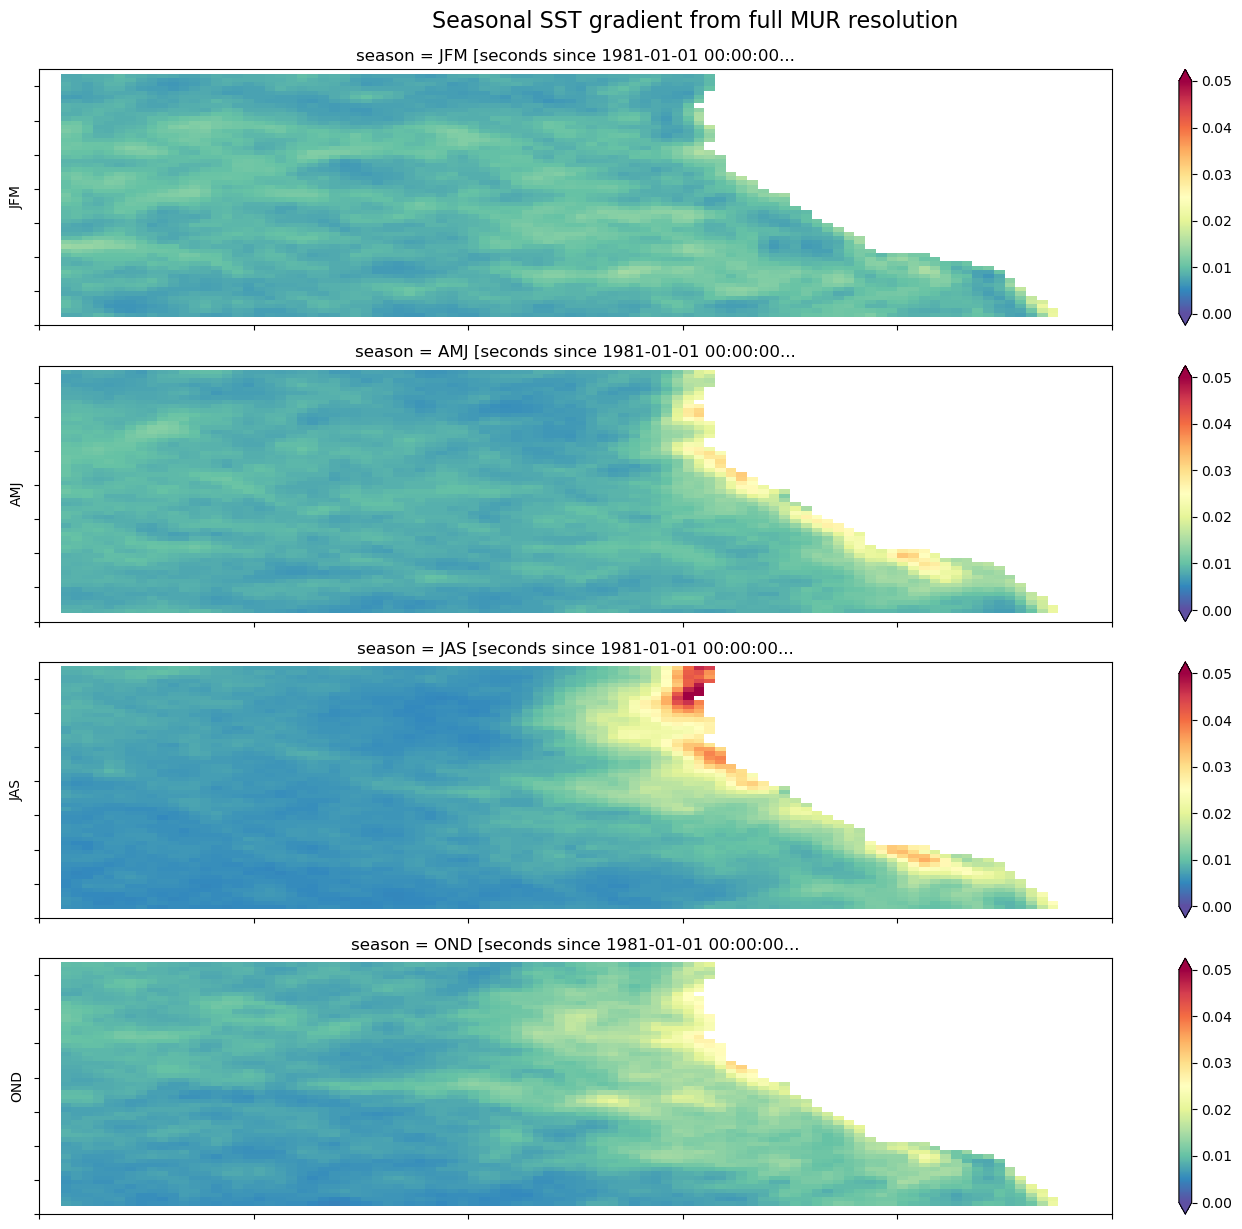

In [24]:
%%time

notnull = pd.notnull(sst_grad[0])
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    sst_grad_seasonal.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=0,
        vmax=0.05,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Seasonal SST gradient from full MUR resolution", fontsize=16, y=1.02)
plt.savefig("mur_fullres_seasonal_grad.png")

#### **Plot the seasonal RMS of SST gradient**

CPU times: user 1min 58s, sys: 5.6 s, total: 2min 4s
Wall time: 1min 8s


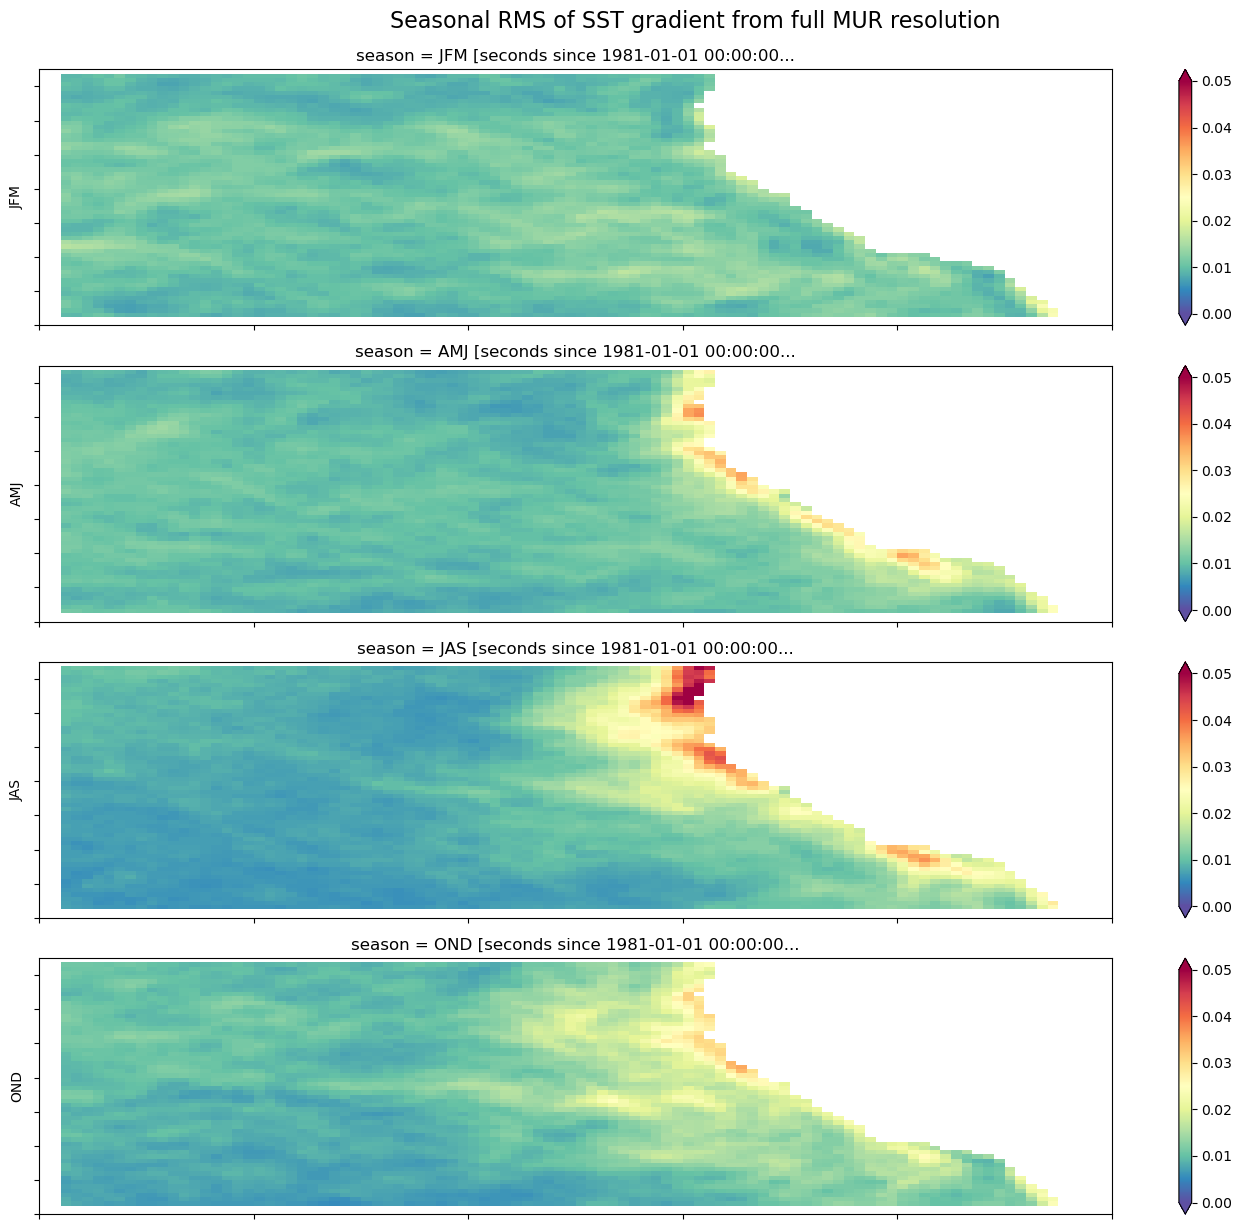

In [25]:
%%time

notnull = pd.notnull(sst_grad[0])
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    rms_seasonal.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=0,
        vmax=0.05,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Seasonal RMS of SST gradient from full MUR resolution", fontsize=16, y=1.02)
plt.savefig("mur_fullres_seasonal_rms_grad.png")

## **Examine the OSTIA dataset and compute SST gradient**

## Authenticate

In [26]:
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

#### Open the dataset

In [27]:
%%time
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_s3.json"
ostia_ds = xr.open_dataset(
    vds_link,
    engine="kerchunk",
    chunks={},
    backend_kwargs={
        "storage_options": {
            "remote_protocol": "s3",
            "remote_options": fs.storage_options
        }
    }
)

CPU times: user 2.27 s, sys: 419 ms, total: 2.69 s
Wall time: 6.96 s


In [28]:
print(ostia_ds)
ostia_ds

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST p

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

#### Subset OSTIA data to the region

In [29]:
ostia_subset = ostia_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range))
ostia_subset

<xarray.DataArray 'analysed_sst' (time: 3652, lat: 300, lon: 500)> Size: 4GB
dask.array<getitem, shape=(3652, 300, 500), dtype=float64, chunksize=(1, 300, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01T12:00:00 ... 2019-12-31T12...
  * lat      (lat) float32 1kB 30.02 30.08 30.12 30.17 ... 44.88 44.92 44.97
  * lon      (lon) float32 2kB -140.0 -139.9 -139.9 ... -115.1 -115.1 -115.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    comment:         OSTIA foundation SST

#### **Compute the SST gradient**

In [30]:
%%time

ostia_mp = ostia_subset.drop_attrs(deep=True)
ostia_mp.metpy.assign_crs(grid_mapping_name='latitude_longitude')

ostia_mp = ostia_subset.drop_attrs(deep=True) # drops attributes, including from coordinate variables
ostia_mp.metpy.assign_crs(grid_mapping_name='latitude_longitude') # adds attribute needed for metpy.xarray.grid_deltas_from_dataarray(): metpy_crs 

x, y = metpy.xarray.grid_deltas_from_dataarray(ostia_mp,'actual')
x = xr.DataArray(x.to('km').squeeze(),coords=[ostia_mp.lat,ostia_mp.lon[1:]])
y = xr.DataArray(y.to('km').squeeze(),coords=[ostia_mp.lat[1:],ostia_mp.lon])

x = xr.concat([x, xr.DataArray(np.full([ostia_mp.sizes['lat'],1],np.nan),coords=[ostia_mp.lat,ostia_mp.lon[:1]])],'lon').metpy.dequantify().chunk(ostia_subset[0,:,:].chunksizes)
y = xr.concat([y, xr.DataArray(np.full([1,ostia_mp.sizes['lon']],np.nan),coords=[ostia_mp.lat[:1],ostia_mp.lon])],'lat').metpy.dequantify().chunk(ostia_subset[0,:,:].chunksizes)

xgrid = x + x.shift(lon=1, fill_value=np.nan)
ygrid = y + y.shift(lat=1, fill_value=np.nan)

dx = xgrid.expand_dims(dim={"time": ostia_mp.time}, axis=0).chunk(ostia_subset.chunksizes)
dy = ygrid.expand_dims(dim={"time": ostia_mp.time}, axis=0).chunk(ostia_subset.chunksizes)

delta_x = (ostia_subset - ostia_subset.shift(lon=2, fill_value=np.nan)).shift(lon=-1, fill_value=np.nan)/(dx)
delta_y = (ostia_subset - ostia_subset.shift(lat=2, fill_value=np.nan)).shift(lat=-1, fill_value=np.nan)/(dy)
ostia_sst_grad = np.sqrt(np.square(delta_x)+np.square(delta_y))

CPU times: user 1.33 s, sys: 32.2 ms, total: 1.36 s
Wall time: 1.36 s


#### **Seasonal average of the SST gradient, with "winter" being January through March**

CPU times: user 6min 21s, sys: 17.4 s, total: 6min 38s
Wall time: 4min 24s


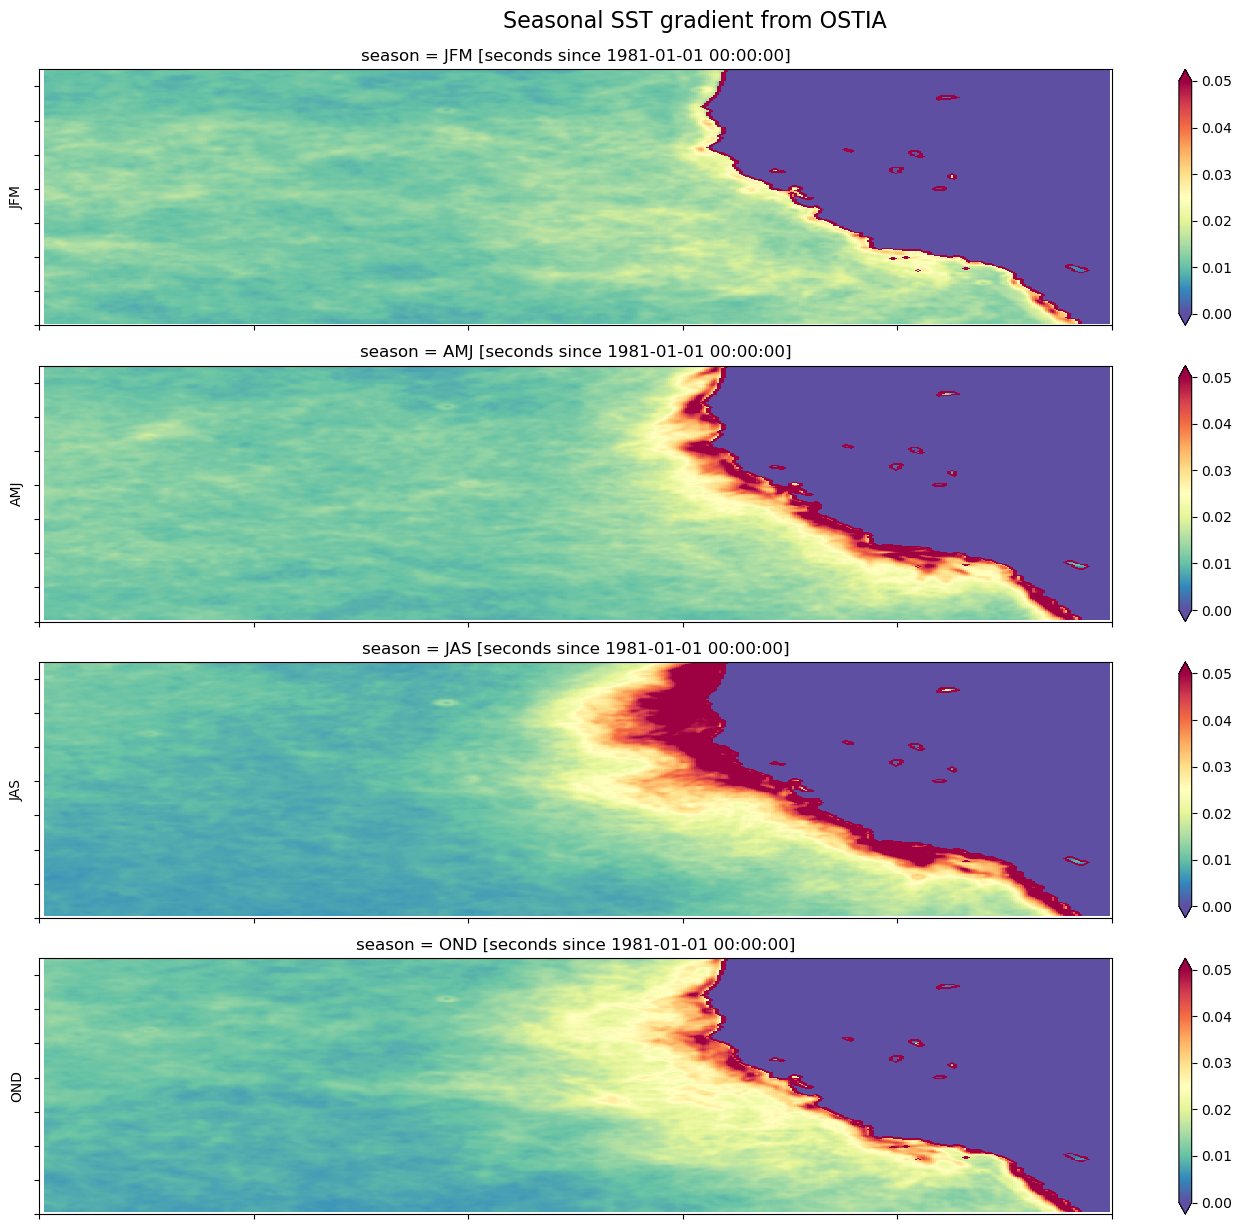

In [31]:
%%time

ostia_sst_grad_seasonal = ostia_sst_grad.groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean()
ostia_sst_grad_seasonal

notnull = pd.notnull(ostia_sst_grad[0])
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    ostia_sst_grad_seasonal.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=0,
        vmax=0.05,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Seasonal SST gradient from OSTIA", fontsize=16, y=1.02)
plt.savefig("ostia_seasonal_grad.png")

#### **Seasonal root-mean-square (RMS) of the SST gradient**

CPU times: user 6min 26s, sys: 13.7 s, total: 6min 40s
Wall time: 4min 27s


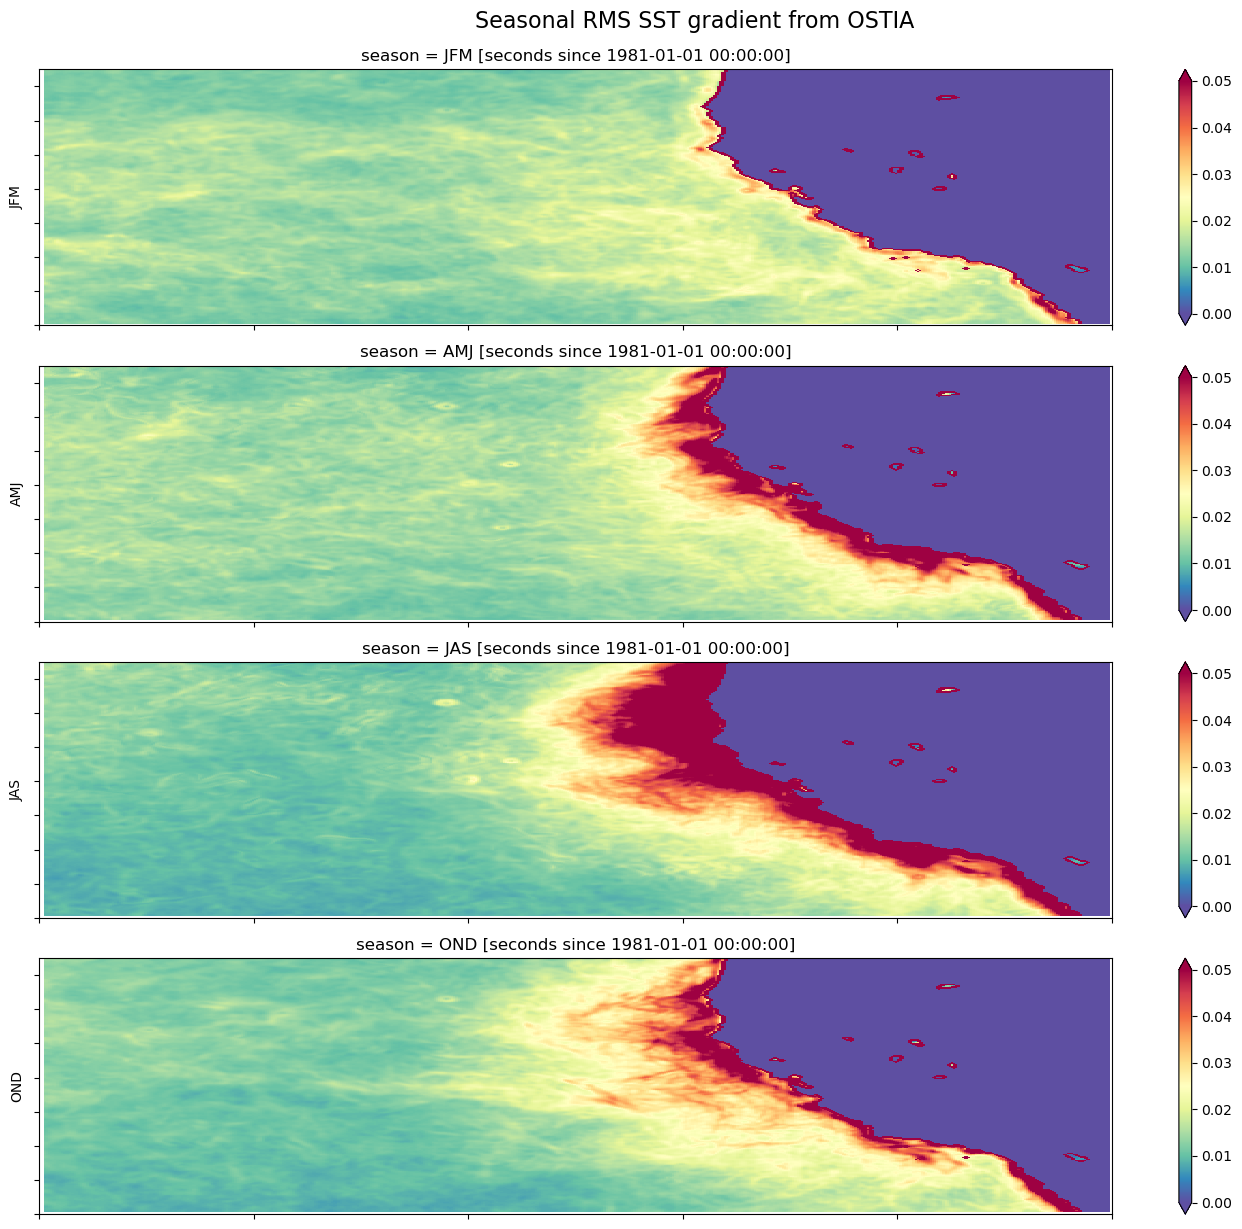

In [32]:
%%time

rms_ostia = np.sqrt(np.square(ostia_sst_grad).groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean())
rms_ostia

notnull = pd.notnull(ostia_sst_grad[0])
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    rms_ostia.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=0,
        vmax=0.05,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Seasonal RMS SST gradient from OSTIA", fontsize=16, y=1.02)
plt.savefig("ostia_seasonal_rms_grad.png")

## **Interpolate MUR to OSTIA and compute the gradient for comparison**

#### Interpolate using linear method

In [33]:
# Uses scipy library
mur_interp = mur_subset.interp(lat=ostia_subset.lat, lon=ostia_subset.lon, method="linear")
mur_interp

<xarray.DataArray 'analysed_sst' (time: 3652, lat: 300, lon: 500)> Size: 4GB
dask.array<transpose, shape=(3652, 300, 500), dtype=float64, chunksize=(1, 300, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01T09:00:00 ... 2019-12-31T09...
  * lat      (lat) float32 1kB 30.02 30.08 30.12 30.17 ... 44.88 44.92 44.97
  * lon      (lon) float32 2kB -140.0 -139.9 -139.9 ... -115.1 -115.1 -115.0
Attributes:
    coverage_content_type:  physicalMeasurement
    long_name:              analysed sea surface temperature
    standard_name:          sea_surface_foundation_temperature
    units:                  kelvin
    valid_max:              32767
    valid_min:              -32767

#### **Compute the SST gradient**

In [34]:
%%time

mur_mp = mur_interp.drop_attrs(deep=True) # drops attributes, including from coordinate variables
mur_mp.metpy.assign_crs(grid_mapping_name='latitude_longitude') # adds attribute needed for metpy.xarray.grid_deltas_from_dataarray(): metpy_crs 

x, y = metpy.xarray.grid_deltas_from_dataarray(mur_mp,'actual')
x = xr.DataArray(x.to('km').squeeze(),coords=[mur_mp.lat,mur_mp.lon[1:]])
y = xr.DataArray(y.to('km').squeeze(),coords=[mur_mp.lat[1:],mur_mp.lon])

x = xr.concat([x, xr.DataArray(np.full([mur_mp.sizes['lat'],1],np.nan),coords=[mur_mp.lat,mur_mp.lon[:1]])],'lon').metpy.dequantify().chunk(mur_interp[0,:,:].chunksizes)
y = xr.concat([y, xr.DataArray(np.full([1,mur_mp.sizes['lon']],np.nan),coords=[mur_mp.lat[:1],mur_mp.lon])],'lat').metpy.dequantify().chunk(mur_interp[0,:,:].chunksizes)

xgrid = x + x.shift(lon=1, fill_value=np.nan)
ygrid = y + y.shift(lat=1, fill_value=np.nan)

dx = xgrid.expand_dims(dim={"time": mur_mp.time}, axis=0).chunk(mur_interp.chunksizes)
dy = ygrid.expand_dims(dim={"time": mur_mp.time}, axis=0).chunk(mur_interp.chunksizes)

delta_x = (mur_interp - mur_interp.shift(lon=2, fill_value=np.nan)).shift(lon=-1, fill_value=np.nan)/(dx)
delta_y = (mur_interp - mur_interp.shift(lat=2, fill_value=np.nan)).shift(lat=-1, fill_value=np.nan)/(dy)
mur_interp_grad = np.sqrt(np.square(delta_x)+np.square(delta_y))

CPU times: user 1.25 s, sys: 334 μs, total: 1.25 s
Wall time: 1.25 s


#### **Seasonal average of the SST gradient, with "winter" being January through March**

CPU times: user 2min, sys: 7.94 s, total: 2min 8s
Wall time: 1min 21s


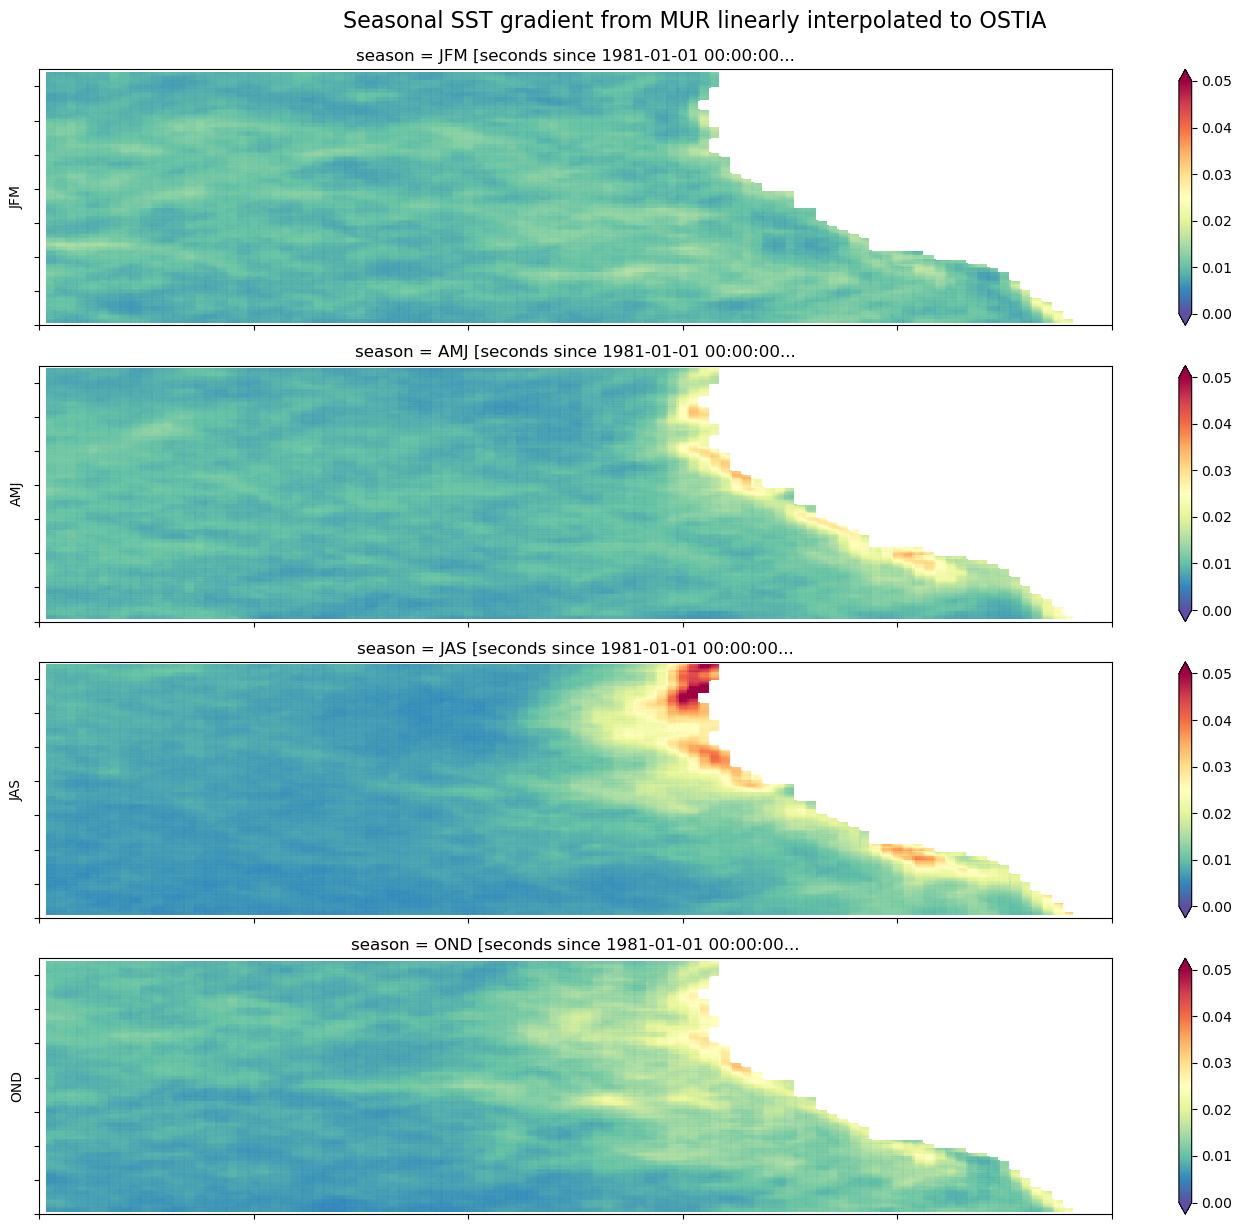

In [35]:
%%time

sst_grad_seasonal = mur_interp_grad.groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean()
sst_grad_seasonal

notnull = pd.notnull(mur_interp[0])
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    sst_grad_seasonal.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=0,
        vmax=0.05,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Seasonal SST gradient from MUR linearly interpolated to OSTIA", fontsize=16, y=1.02)
plt.savefig("mur_linear_seasonal_grad.png")

#### **Seasonal root-mean-square (RMS) of the SST gradient**

CPU times: user 1min 58s, sys: 7.84 s, total: 2min 6s
Wall time: 1min 19s


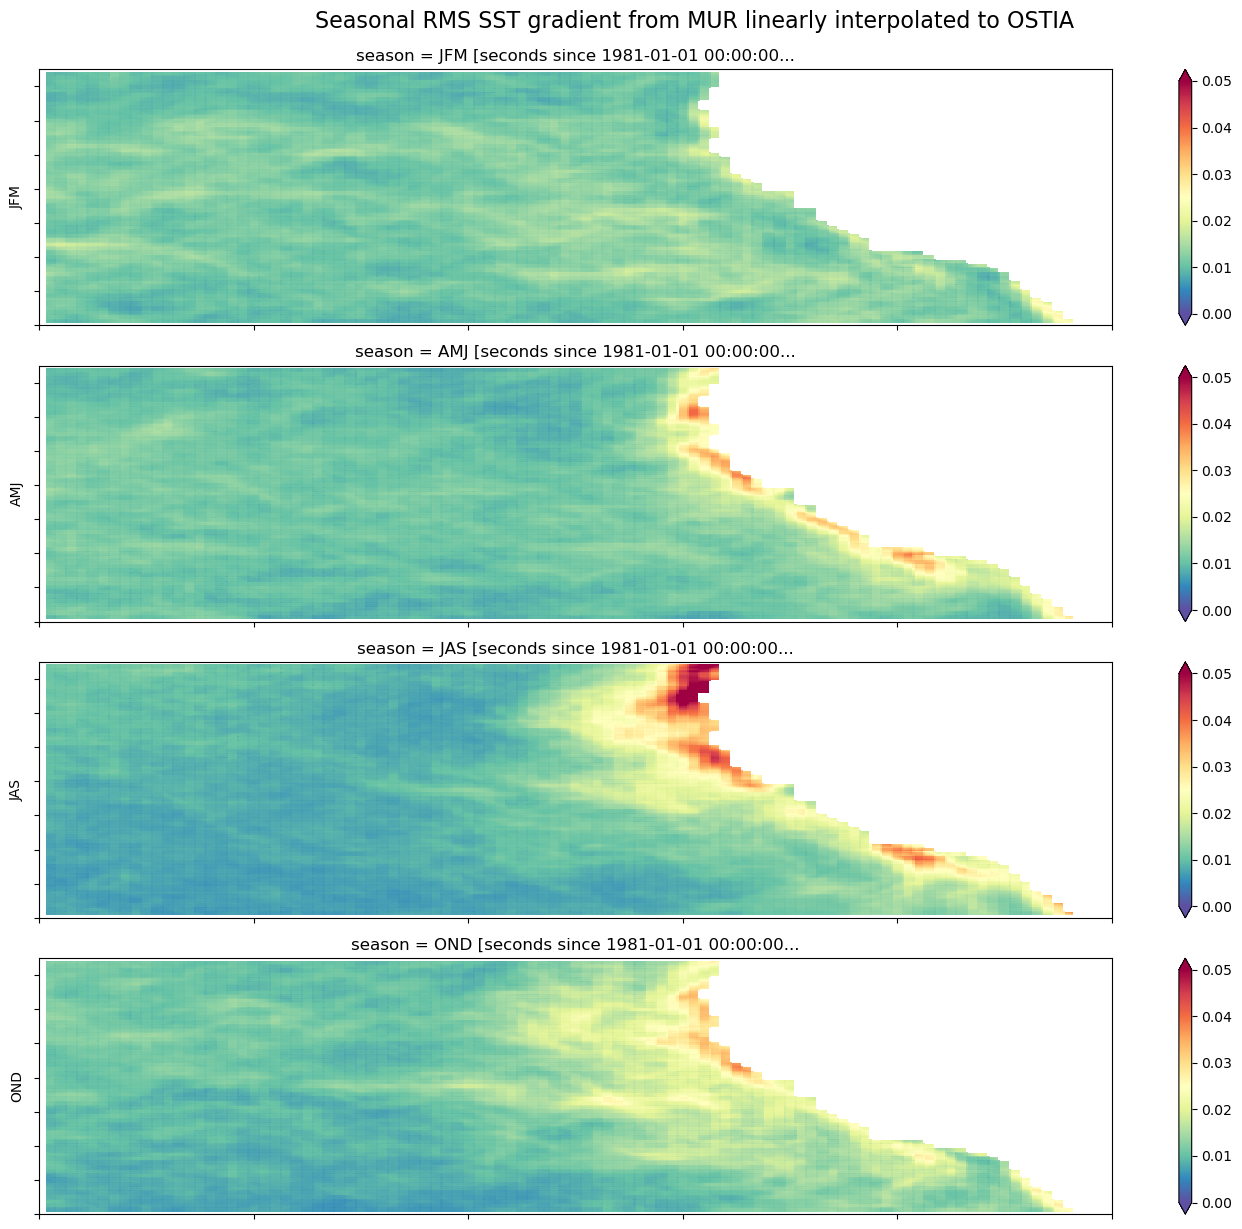

In [36]:
%%time

rms_mur = np.sqrt(np.square(mur_interp_grad).groupby(time=xr.groupers.SeasonGrouper(["JFM","AMJ","JAS","OND"])).mean())
rms_mur

notnull = pd.notnull(mur_interp[0])
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    rms_mur.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=0,
        vmax=0.05,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Seasonal RMS SST gradient from MUR linearly interpolated to OSTIA", fontsize=16, y=1.02)
plt.savefig("mur_linear_seasonal_rms_grad.png")

#### **Seasonal histogram of the SST gradient variability (RMS) in OSTIA**

CPU times: user 6min 30s, sys: 13.4 s, total: 6min 43s
Wall time: 4min 31s


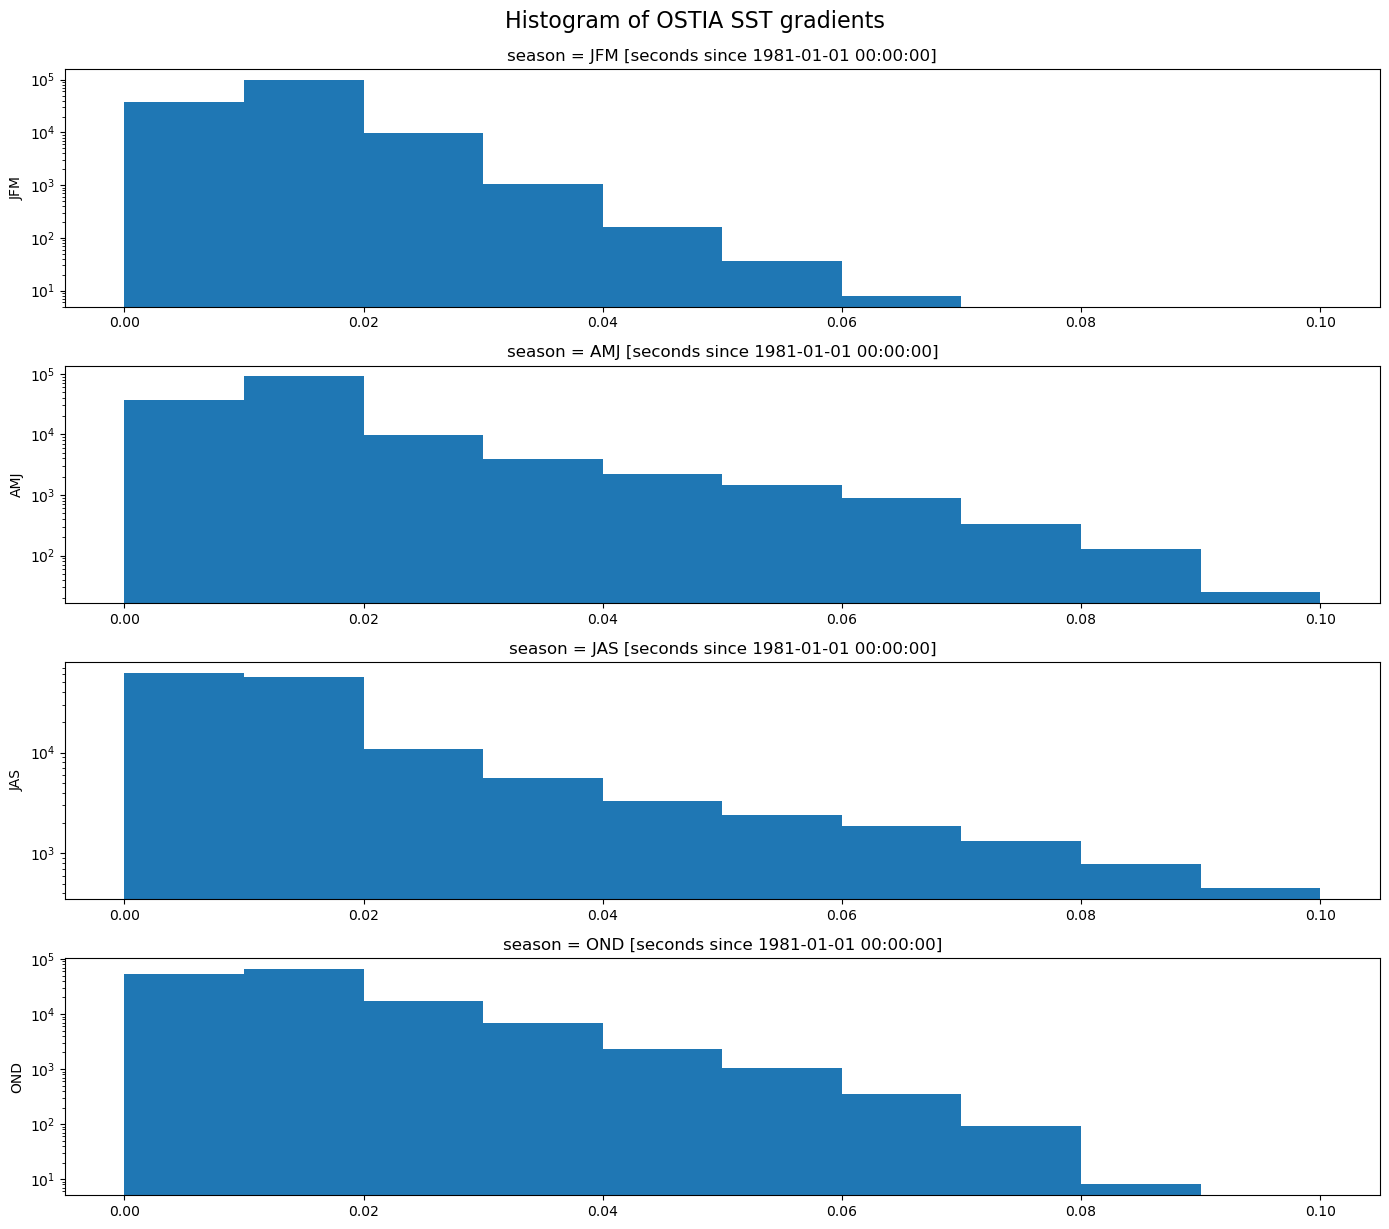

In [37]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    rms_ostia.sel(season=season).plot.hist(
        ax=axes[i],
        range=(0,0.1)
    )
    axes[i].set_yscale('log', base=10)
    axes[i].set_ylabel(season)
plt.tight_layout()
fig.suptitle("Histogram of OSTIA SST gradients", fontsize=16, y=1.02)
plt.savefig("ostia_grad_hist.png")

#### **Seasonal histogram of the SST gradient variability (RMS) in interpolated MUR**

CPU times: user 2min 2s, sys: 7.86 s, total: 2min 10s
Wall time: 1min 22s


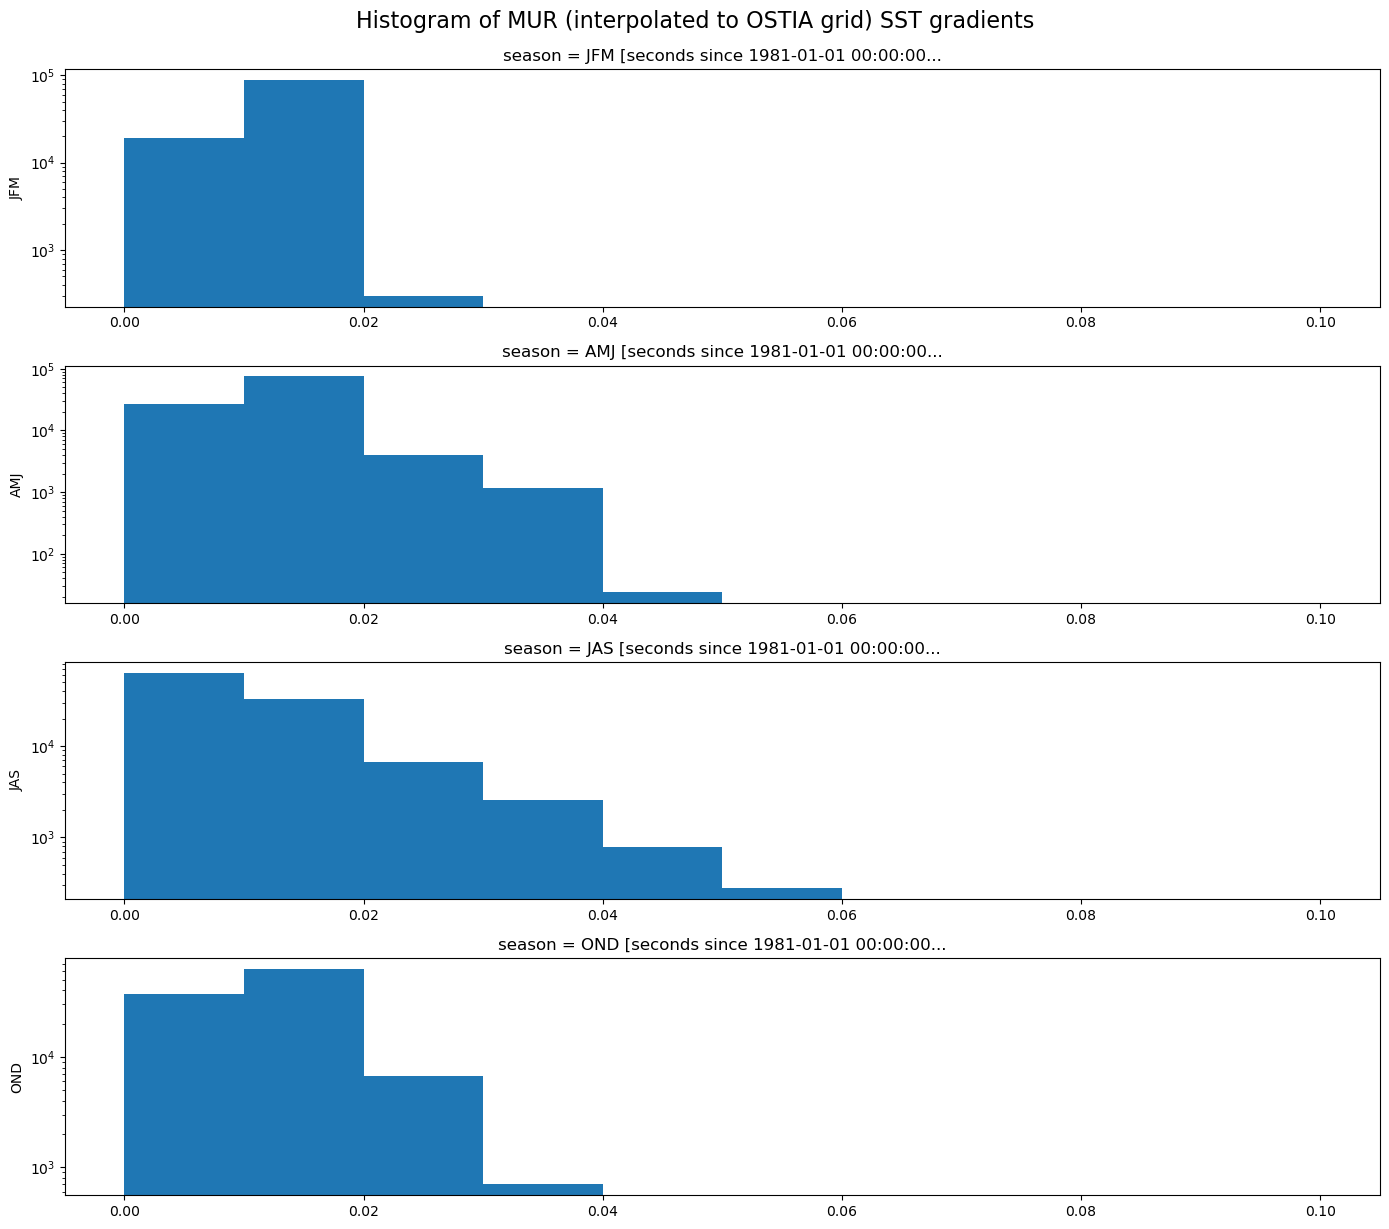

In [38]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("JFM", "AMJ", "JAS", "OND")): 
    rms_mur.sel(season=season).plot.hist(
        ax=axes[i],
        range=(0,0.1)
    )
    axes[i].set_yscale('log', base=10)
    axes[i].set_ylabel(season)
plt.tight_layout()
fig.suptitle("Histogram of MUR (interpolated to OSTIA grid) SST gradients", fontsize=16, y=1.02)
plt.savefig("mur_grad_hist.png")

*Disclaimer: Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*